Seattle has a reputation for being a pet friendly city. By some estimates, there are more dogs in the city than there are children, an impressive feat for a place as populous as Seattle. [Seattle's open data portal](https://data.seattle.gov/) contains, among other things, information on [licensed pets](https://data.seattle.gov/Community/Seattle-Pet-Licenses/jguv-t9rb).
 
Awesome!

Let's explore the kinds of insights that can be found by looking at this data.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn_wordcloud import venn2_wordcloud

%matplotlib inline

In [2]:
license_file = "pet_licenses.csv"
# Alternatively, the license file may be read from here
# license_file = "https://data.seattle.gov/api/views/jguv-t9rb/rows.csv?accessType=DOWNLOAD"

pets = pd.read_csv(license_file)

## Cleaning the data
Let's inspect the dataset to ensure it's properly cleaned before any analysis is run on it.

First, what does our data look like?

In [3]:
pets.shape  # (rows, columns)

(53663, 7)

In [4]:
pets.columns

Index(['License Issue Date', 'License Number', 'Animal's Name', 'Species',
       'Primary Breed', 'Secondary Breed', 'ZIP Code'],
      dtype='object')

Let's rename the columns so they're easier to work with

In [8]:
pets.columns = [
    "license_issued", "license", "name",
    "species", "primary_breed",
    "secondary_breed", "zipcode",
]

In [9]:
# how many NaNs does each colum have?
# https://stackoverflow.com/a/26266451
pets.isna().sum()

license_issued         0
license                0
name                 709
species                0
primary_breed          0
secondary_breed    32083
zipcode              361
dtype: int64

Given the amount of `NaN` values in the `secondary_breed` column, most owners either don't know what breed their pet is mixed with, or left that section blank when applying for a license.

A fair number of licenses also don't have the `name` listed. It's possible these animals were either babies or recently adopted at the time of their licensing.

![cute beagle puppy](https://images.pexels.com/photos/460823/pexels-photo-460823.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)
Cute!

In either case, let's replace the missing values from `secondary_breed` and drop the rest of the `NaN`s

In [15]:
pets = (pets
    .fillna({"secondary_breed": ""})
    .dropna()
)

The `zipcode` field is useful if we want to analyze pet information based on location. To make it easy, let's only use rows that contain a 5-digit ZIP code.

In [14]:
pets = pets[pets.zipcode.str.match("^\d{5}$")]

In [19]:
pets.describe()

,license_issued,license,name,species,primary_breed,secondary_breed,zipcode
count,52444,52444,52444,52444,52444,52444,52444
unique,1060,52419,13977,4,335,256,93
top,January 16 2018,133239,Lucy,Dog,Domestic Shorthair,,98115
freq,448,3,453,35188,9936,31467,4851


`license_issued` looks like it's a string - it would be more useful as a datetime object

In [20]:
pets["license_issued"] = pd.to_datetime(pets["license_issued"])

There are also duplicate licenses that we should get rid of

In [21]:
pets.drop_duplicates(subset=["license"], inplace=True)

Our data should be clean enough now, let's move on to the analysis.

## Cats & Dogs
Almost all licenses are for either cats or dogs.

![cat and dog together](https://images.pexels.com/photos/46024/pexels-photo-46024.jpeg?auto=compress&cs=tinysrgb&h=750&w=1260)

In [22]:
pets.groupby("species").species.count().sort_values(ascending=False)

species
Dog     35170
Cat     17207
Goat       38
Pig         4
Name: species, dtype: int64

In [23]:
cats = pets[pets.species == "Cat"]
dogs = pets[pets.species == "Dog"]

### Most common names

In [24]:
cat_names = cats.name.value_counts()
dog_names = dogs.name.value_counts()

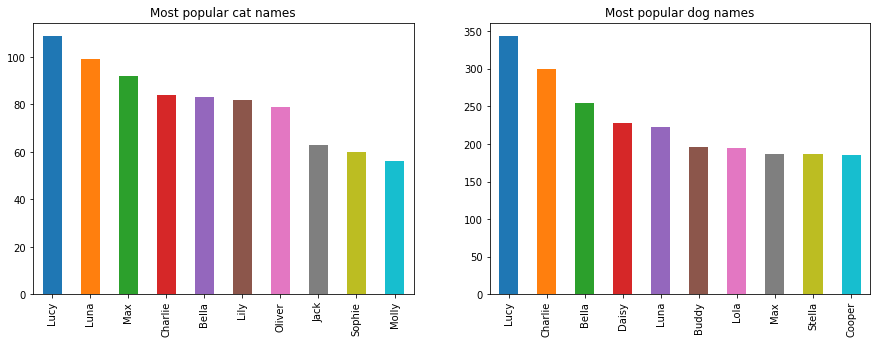

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

cat_names.head(10).plot.bar(
    title="Most popular cat names",
    ax=ax[0],
)

dog_names.head(10).plot.bar(
    title="Most popular dog names",
    ax=ax[1],
)

plt.show()

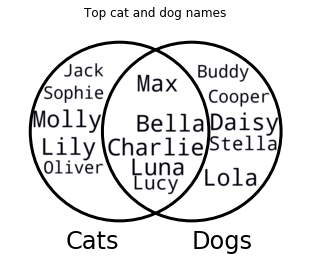

In [26]:
fig, ax = plt.subplots(1, 1)

ax.set_title("Top cat and dog names")
venn2_wordcloud(
    [
        set(cat_names.head(10).index),
        set(dog_names.head(10).index),
    ],
    set_labels=("Cats", "Dogs"),
    ax=ax,
)

plt.show()

**Conclusion**: if you're ever on the street and bump into a dog (or cat!), your best bet is to call it Lucy.

### Breed
Which breeds are the most common?

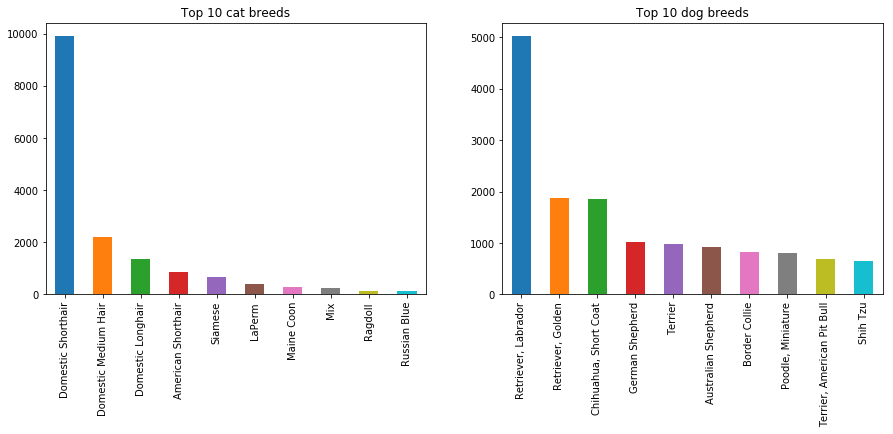

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

cats.primary_breed.value_counts().head(10).plot.bar(title="Top 10 cat breeds", ax=ax[0])
dogs.primary_breed.value_counts().head(10).plot.bar(title="Top 10 dog breeds", ax=ax[1])

We've all heard of the cliché of getting your loved ones a pet for Valentine's day, but apparently February is the least popular month to license a pet.

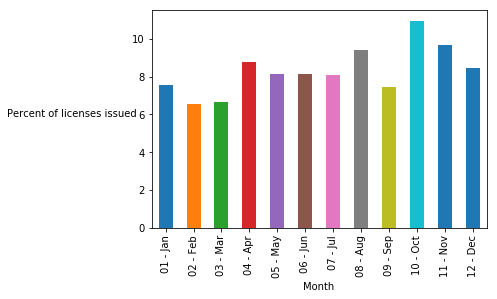

In [28]:
ax = (pets
 .license_issued
 .apply(lambda date: date.strftime("%m - %b"))
 .value_counts(normalize=True).apply(lambda percent: percent * 100)
 .sort_index()
 .plot.bar()
)

ax.set_ylabel("Percent of licenses issued", rotation=0, labelpad=60)
ax.set_xlabel("Month")

ax

## Where are the pets?
Are there specific places within Seattle that have more pets than others?

In [34]:
pets.zipcode.value_counts().head(10)

98115    4850
98103    4539
98117    3929
98125    3019
98107    2518
98118    2496
98122    2484
98199    2337
98116    2186
98105    2138
Name: zipcode, dtype: int64

What would that look like in a map?

In [35]:
import folium
import requests

SEATTLE_COORDINATES = (47.63, -122.27)
DEFAULT_ZOOM = 10
# Thank you, SeattleIO, for providing this!
ZIPCODE_GEO_URL = (
    "https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/master/data/zip-codes.geojson"
)
ZIPCODE_GEO_TEXT = requests.get(ZIPCODE_GEO_URL).text

def plot_data_by_zipcode(data,
                         location=SEATTLE_COORDINATES,
                         zoom_start=DEFAULT_ZOOM,
                         geo_data=ZIPCODE_GEO_TEXT, 
                         key_on="feature.properties.ZCTA5CE10",
                         fill_color="PuBuGn",
                         **kwargs):
    """Plot data on a choropleth map
    
    With the exception of map_coordinates and default_zoom, all arguments
    in this function are passed to folium.Map.choropleth. map_coordinates
    and default_zoom arguments are passed in as parameters to the folium.Map
    constructor.
    
    Args:
        data - data to pass into the choropleth map. Corresponds to the
               data argument passed into folium.Map.choropleth and is usually
               a pandas DataFrame or Series.
        **kwargs - Additional arguments to pass to folium.Map.choropleth
        
    Returns:
        A folium.Map instance containing a choropleth of mapped data
    """    
    map_ = folium.Map(location=location, zoom_start=zoom_start)

    map_.choropleth(
        geo_data=geo_data,
        data=data,
        key_on=key_on,
        fill_color=fill_color,
        **kwargs,
    )
    
    return map_

ConnectionError: HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /seattleio/seattle-boundaries-data/master/data/zip-codes.geojson (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f005ed4ce80>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))

In [14]:
corgi_count_by_zipcode = corgis.groupby("ZIP Code")["ZIP Code"].count().sort_values(ascending=False)

plot_data_by_zipcode(data=corgi_count_by_zipcode, legend_name="Seattle Corgi Population by Zipcode")

# Is that any different than the distribution of all dogs?

In [20]:
dogs_by_zipcode = dogs.groupby("ZIP Code")["ZIP Code"].count().sort_values(ascending=False)

plot_data_by_zipcode(dogs_by_zipcode, legend_name="Dog Count by Zipcode")

# Where do the cool cats live?

In [16]:
cats = pets[pets.Species == "Cat"]

cats_by_zipcode = cats.groupby("ZIP Code")["ZIP Code"].count()

plot_data_by_zipcode(data=cats_by_zipcode, legend_name="Cat Count by Zipcode")

# Conclusion - go to Green Lake